In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import re, copy, os
from scipy.stats import poisson
from sklearn.metrics import log_loss, accuracy_score

SEASON_SPLIT = 2024

## Reading in data from csv files

In [2]:
matches = pd.read_csv('matches.csv', index_col=0)
print(matches.shape)

(3005, 40)


In [3]:
next_matches = pd.read_csv('next_matches.csv', index_col=0)
print(next_matches.shape)

(20, 22)


In [4]:
history_matches = pd.read_csv('history.csv', index_col=0)
print(history_matches.shape)

(24281, 15)


In [5]:
# getting the matches of the desired league
LEAGUE = 'Premier League'
league_matches = matches[matches['Comp'] == LEAGUE]
league_history_matches = history_matches[history_matches['Comp'] == LEAGUE]
league_matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,2CrdY,Fls,Fld,Off,Crs,Int,TklW,Won%,SCA,GCA
0,2025-09-20,12:30 (21:30),Premier League,Matchweek 5,Sat,Home,W,2,1,Everton,...,0.0,11.0,10.0,1.0,12.0,12.0,7.0,55.9,16.0,4.0
1,2025-09-21,16:30 (01:30),Premier League,Matchweek 5,Sun,Home,D,1,1,Manchester City,...,0.0,11.0,10.0,4.0,32.0,5.0,13.0,46.9,22.0,2.0
2,2025-09-20,15:00 (00:00),Premier League,Matchweek 5,Sat,Away,D,2,2,Brighton,...,0.0,13.0,10.0,1.0,32.0,9.0,10.0,48.0,21.0,1.0
3,2025-09-21,14:00 (23:00),Premier League,Matchweek 5,Sun,Home,D,0,0,Newcastle Utd,...,0.0,7.0,8.0,3.0,21.0,16.0,8.0,52.9,17.0,0.0
4,2025-09-20,15:00 (00:00),Premier League,Matchweek 5,Sat,Away,W,2,1,West Ham,...,0.0,5.0,15.0,2.0,18.0,10.0,16.0,60.9,33.0,3.0


## Date Exploration and Analysis

In [6]:
league_matches['Team'].value_counts()

Team
Liverpool                   119
Arsenal                     119
Tottenham Hotspur           119
Bournemouth                 119
Crystal Palace              119
Chelsea                     119
Fulham                      119
Manchester City             119
Everton                     119
Wolverhampton Wanderers     119
Manchester United           119
Newcastle United            119
Brighton and Hove Albion    119
Brentford                   119
Nottingham Forest           119
West Ham United             119
Aston Villa                 119
Leicester City               76
Southampton                  76
Burnley                      43
Leeds United                 43
Luton Town                   38
Ipswich Town                 38
Sheffield United             38
Sunderland                    5
Name: count, dtype: int64

In [7]:
league_matches['Opponent'].value_counts()

Opponent
Everton            119
Manchester City    119
Brighton           119
Newcastle Utd      119
West Ham           119
Manchester Utd     119
Aston Villa        119
Brentford          119
Arsenal            119
Liverpool          119
Chelsea            119
Wolves             119
Bournemouth        119
Tottenham          119
Nott'ham Forest    119
Fulham             119
Crystal Palace     119
Southampton         76
Leicester City      76
Burnley             43
Leeds United        43
Sheffield Utd       38
Ipswich Town        38
Luton Town          38
Sunderland           5
Name: count, dtype: int64

In [8]:
league_matches.dtypes

Date              object
Time              object
Comp              object
Round             object
Day               object
Venue             object
Result            object
GF                object
GA                object
Opponent          object
xG               float64
xGA              float64
Poss             float64
Attendance       float64
Captain           object
Formation         object
Opp Formation     object
Referee           object
Match Report      object
Notes             object
Season             int64
Team              object
Sh               float64
SoT              float64
Dist             float64
FK               float64
PK               float64
PKatt            float64
CrdY             float64
CrdR             float64
2CrdY            float64
Fls              float64
Fld              float64
Off              float64
Crs              float64
Int              float64
TklW             float64
Won%             float64
SCA              float64
GCA              float64


In [9]:
team_names = sorted(league_matches['Team'].unique())
opp_names = sorted(league_matches['Opponent'].unique())

exculsive_team_names = []
exculsive_opp_names = []

# finding out the team names that are written differently in the opponent column
for i in team_names:
    if (i not in opp_names):
        exculsive_team_names.append(i)
        print(i)

print('---------------------------')

for i in opp_names:
    if (i not in team_names):
        exculsive_opp_names.append(i)
        print(i)

Brighton and Hove Albion
Manchester United
Newcastle United
Nottingham Forest
Sheffield United
Tottenham Hotspur
West Ham United
Wolverhampton Wanderers
---------------------------
Brighton
Manchester Utd
Newcastle Utd
Nott'ham Forest
Sheffield Utd
Tottenham
West Ham
Wolves


In [10]:
# creating class to map team names written differently in opponent column to 
# corresponding team names.
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {}

for team_name, opp_name in zip(exculsive_team_names, exculsive_opp_names):
    map_values[team_name] = opp_name

mapping = MissingDict(**map_values)

In [11]:
# applying mapping to ensure consistent team names
matches['Team'] = matches['Team'].map(mapping)
# creating a dictionary of team codes to ensure consistent team codes for each
# team
team_mapping_dict = {key: value for key, value in zip(matches['Team'], matches['Team'].astype('category').cat.codes)}
matches['Team_code'] = matches['Team'].map(team_mapping_dict)
matches['Opp_code'] = matches['Opponent'].map(team_mapping_dict)

# simplifying date and venue into respective codes
matches['Date'] = pd.to_datetime(matches['Date'])
matches['Venue_code'] = matches['Venue'].astype('category').cat.codes
matches['Hour'] = matches['Time'].str.replace(":.+", "", regex=True).astype('int')
matches['Day_code'] = matches['Date'].dt.dayofweek

matches['Target'] = matches['Result'].astype('category').cat.codes

matches['GF'] = matches['GF'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
matches['GA'] = matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))

In [12]:
matches.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,...,TklW,Won%,SCA,GCA,Team_code,Opp_code,Venue_code,Hour,Day_code,Target
0,2025-09-20,12:30 (21:30),Premier League,Matchweek 5,Sat,Home,W,2,1,Everton,...,7.0,55.9,16.0,4.0,13,8.0,1,12,5,2
1,2025-09-21,16:30 (01:30),Premier League,Matchweek 5,Sun,Home,D,1,1,Manchester City,...,13.0,46.9,22.0,2.0,0,15.0,1,16,6,0
2,2025-09-20,15:00 (00:00),Premier League,Matchweek 5,Sat,Away,D,2,2,Brighton,...,10.0,48.0,21.0,1.0,22,4.0,0,15,5,0
3,2025-09-21,14:00 (23:00),Premier League,Matchweek 5,Sun,Home,D,0,0,Newcastle Utd,...,8.0,52.9,17.0,0.0,2,17.0,1,14,6,0
4,2025-09-20,15:00 (00:00),Premier League,Matchweek 5,Sat,Away,W,2,1,West Ham,...,16.0,60.9,33.0,3.0,7,23.0,0,15,5,2


In [13]:
# removing columns that are of no importance or repeated
matches = matches.drop(columns=['Time', 'Day', 'Result', 'Attendance',
                                'Match Report', 'Notes','Captain', 'Formation',
                                'Opp Formation', 'Referee'])

In [14]:
matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
Venue                 object
GF                     int64
GA                     int64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Sh                   float64
SoT                  float64
Dist                 float64
FK                   float64
PK                   float64
PKatt                float64
CrdY                 float64
CrdR                 float64
2CrdY                float64
Fls                  float64
Fld                  float64
Off                  float64
Crs                  float64
Int                  float64
TklW                 float64
Won%                 float64
SCA                  float64
GCA                  float64
Team_code              int64
Opp_code             float64
Venue_code              int8
Hour                   int64
Day_code      

In [15]:
# encoding for next matches
next_matches['Team'] = next_matches['Team'].map(mapping)
next_matches['Team_code'] = next_matches['Team'].map(team_mapping_dict)
next_matches['Opp_code'] = next_matches['Opponent'].map(team_mapping_dict)

next_matches['Date'] = pd.to_datetime(next_matches['Date'])
next_matches['Venue_code'] = next_matches['Venue'].astype('category').cat.codes
next_matches['Hour'] = next_matches['Time'].str.replace(":.+", "", regex=True).astype('int')
next_matches['Day_code'] = next_matches['Date'].dt.dayofweek

In [16]:
next_matches = next_matches.drop(columns=['Time', 'Day', 'Venue', 'Result', 
                                          'Attendance', 'Match Report', 'Notes',
                                          'Captain', 'Formation',
                                          'Opp Formation', 'Referee'])

In [17]:
next_matches.dtypes

Date          datetime64[ns]
Comp                  object
Round                 object
GF                   float64
GA                   float64
Opponent              object
xG                   float64
xGA                  float64
Poss                 float64
Season                 int64
Team                  object
Team_code              int64
Opp_code               int64
Venue_code              int8
Hour                   int64
Day_code               int32
dtype: object

In [18]:
# function to get the Target value based on GF and GA
def get_Target(row):
    if row['GF'] > row['GA']:
        return 2
    elif row['GF'] < row['GA']:
        return 1
    else:
        return 0

In [19]:
# encoding for history matches
history_matches['Team'] = history_matches['Team'].map(mapping)
history_matches['Home'] = history_matches['Home'].map(mapping)
history_matches['Away'] = history_matches['Away'].map(mapping)
history_matches['Date'] = pd.to_datetime(history_matches['Date'])
history_matches['GF'] = history_matches['Score'].apply(lambda score: (score.split('–')[0]))
history_matches['GA'] = history_matches['Score'].apply(lambda score: score.split('–')[1])
history_matches['GF'] = history_matches['GF'].apply(lambda x: int(re.search(r'[0-9]+$', x).group(0)))
history_matches['GA'] = history_matches['GA'].apply(lambda x: int(re.search(r'^[0-9]+', x).group(0)))
history_matches['Target'] = history_matches.apply(get_Target, axis=1)

# ensuring consistent team and Opponent column across dataframes
for index, row in history_matches.iterrows():
    if row['Team'] == row['Away']:
        temp = row['Home']
        history_matches.loc[index, 'Home'] = row['Away']
        history_matches.loc[index, 'Away'] = temp
        temp = row['GF']
        history_matches.loc[index, 'GF'] = row['GA']
        history_matches.loc[index, 'GA'] = temp

history_matches['Opponent'] = history_matches['Away']

In [20]:
history_matches = history_matches.drop(columns=['Time', 'Day', 'Venue', 
                                                'Attendance', 
                                                'Notes', 'Referee',
                                                'Home', 'Away'])

In [21]:
history_matches.dtypes

Comp                object
Round               object
Date        datetime64[ns]
xG                 float64
Score               object
xG.1               float64
Team                object
GF                   int64
GA                   int64
Target               int64
Opponent            object
dtype: object

In [22]:
# function to compute rolling averages of given columns for each match
def rolling_avgs(group, cols, new_cols, num_past_matches_considered=3):
    group = group.sort_values('Date')
    # not considering the current match and must have at least 1 match to calculate
    rolling_stats = group[cols].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).mean()
    group[new_cols] = rolling_stats.fillna(0)
    return group

In [23]:
# rolling avgs for matches across the desired league
league_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA']
league_ravg_new_cols = [f"{c}league_rolling" for c in league_ravg_cols]

In [24]:
# stats for last match
last_ravg_cols = ['GF', 'GA', 'Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 
             'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%',
             'SCA', 'GCA', 'xG', 'xGA', 'Target']
last_ravg_new_cols = [f"{c}last_rolling" for c in last_ravg_cols]

In [25]:
# rolling avgs for matches across all head to head matches
hth_ravg_cols = ['xG', 'xG.1', 'GF', 'GA']
hth_ravg_new_cols = [f"{c}hth_rolling" for c in hth_ravg_cols]

In [26]:
# function to compute rolling average of rest days for each match
def rolling_avg_match_rest(group, num_past_matches_considered=3):
    group = group.sort_values('Date')
    group['days_diff'] = group['Date'].diff().dt.days
    rolling_stats = group['days_diff'].rolling(num_past_matches_considered, 
                                        min_periods=1).mean()
    group[f'rolling_rests_{num_past_matches_considered}'] = rolling_stats.fillna(0)
    return group

In [27]:
# function to compute rolling number of wins for each match
def rolling_match_results(group, name, num_past_matches_considered=3):
    group = group.sort_values('Date')
    group['is_win'] = (group['Target'] == 2).astype(int)
    rolling_stats = group['is_win'].rolling(num_past_matches_considered, 
                                        closed='left', min_periods=1).sum()
    group[f'{name}num_wins_rolling'] = rolling_stats.fillna(0)
    return group

In [28]:
all_matches = pd.concat([matches, next_matches])
# computing rolling average rest days for all matches
all_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
all_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avg_match_rest(x,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)

# getting the rolling averages for all league matches
league_matches = all_matches[all_matches['Comp'] == LEAGUE]
team_league_matches = league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, league_ravg_cols, league_ravg_new_cols),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)
team_league_matches = team_league_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'league'),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)

# getting the rolling averages for last match
team_last_matches = all_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_avgs(x, last_ravg_cols, last_ravg_new_cols,1),
                                                                         include_groups=False).reset_index(level=0).reset_index(drop=True)

# getting the rolling averages for head to head history
hth_and_next_matches = pd.concat([history_matches, next_matches])
team_hth_matches = hth_and_next_matches.groupby(['Team', 'Opponent'], group_keys=True).apply(lambda x: rolling_avgs(x, hth_ravg_cols, hth_ravg_new_cols),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)

team_hth_matches = team_hth_matches.groupby('Team', group_keys=True).apply(lambda x: rolling_match_results(x, 'hth'),
                                                                               include_groups=False).reset_index(level=0).reset_index(drop=True)


In [29]:
# getting a copy of the matches dataframes to prepare for merging of opponent stats
opp_team_league_matches = team_league_matches.copy()
opp_team_league_matches = opp_team_league_matches.add_prefix('Opp_')

opp_team_last_matches = team_last_matches.copy()
opp_team_last_matches = opp_team_last_matches.add_prefix('Opp_')

In [30]:
# Merging matches with their opponent stats
team_league_matches = team_league_matches.merge(opp_team_league_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_league_matches = team_league_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_Target', 'Opp_days_diff', 'Opp_is_win'])
team_last_matches = team_last_matches.merge(opp_team_last_matches,
                                         left_on=['Date', 'Opponent'],
                                         right_on=['Opp_Date', 'Opp_Team'],
                                         how='left')
team_last_matches = team_last_matches.drop(columns=['Opp_Date', 'Opp_Team', 'Opp_Comp', 'Opp_Round',
                                  'Opp_GF', 'Opp_GA', 'Opp_Opponent','Opp_xG',
                                  'Opp_xGA', 'Opp_Season', 'Opp_Team_code', 'Opp_Opp_code',
                                  'Opp_Venue_code', 'Opp_Hour', 'Opp_Day_code',
                                  'Opp_days_diff'])

In [31]:
# merging matches, next matches, head to head history dataframes together into one
last_ravg_new_cols_merge = copy.deepcopy(last_ravg_new_cols)
hth_ravg_new_cols_merge = copy.deepcopy(hth_ravg_new_cols)
last_ravg_new_cols_merge = last_ravg_new_cols_merge + ['Opp_' + column for column in last_ravg_new_cols_merge]
last_ravg_new_cols_merge.append('Date')
hth_ravg_new_cols_merge.append('Date')
last_ravg_new_cols_merge.append('Team')
hth_ravg_new_cols_merge.append('Team')
hth_ravg_new_cols_merge.append('hthnum_wins_rolling')
team_matches = team_league_matches.merge(team_last_matches[last_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')
team_matches = team_matches.merge(team_hth_matches[hth_ravg_new_cols_merge],
                                                on=['Date', 'Team'], how='left')

In [32]:
team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Opp_SCAlast_rolling,Opp_GCAlast_rolling,Opp_xGlast_rolling,Opp_xGAlast_rolling,Opp_Targetlast_rolling,xGhth_rolling,xG.1hth_rolling,GFhth_rolling,GAhth_rolling,hthnum_wins_rolling
0,Arsenal,2022-08-05,Premier League,Matchweek 1,Away,2.0,0.0,Crystal Palace,1.0,1.2,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Arsenal,2022-08-13,Premier League,Matchweek 2,Home,4.0,2.0,Leicester City,2.7,0.5,...,25.0,4.0,0.6,0.8,0.0,1.000000,0.700000,1.333333,0.333333,3.0
2,Arsenal,2022-08-20,Premier League,Matchweek 3,Away,3.0,0.0,Bournemouth,1.3,0.3,...,4.0,0.0,0.1,1.7,1.0,0.866667,1.100000,1.333333,1.000000,3.0
3,Arsenal,2022-08-27,Premier League,Matchweek 4,Home,2.0,1.0,Fulham,2.6,0.8,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
4,Arsenal,2022-08-31,Premier League,Matchweek 5,Home,2.0,1.0,Aston Villa,2.4,0.4,...,17.0,0.0,0.5,0.6,1.0,1.450000,1.400000,2.666667,0.666667,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,Wolves,2025-08-23,Premier League,Matchweek 2,Away,0.0,1.0,Bournemouth,0.5,1.3,...,18.0,3.0,1.7,2.2,1.0,NaN,NaN,NaN,NaN,NaN
2396,Wolves,2025-08-30,Premier League,Matchweek 3,Home,2.0,3.0,Everton,1.1,1.9,...,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN
2397,Wolves,2025-09-13,Premier League,Matchweek 4,Away,0.0,1.0,Newcastle Utd,0.5,1.5,...,15.0,0.0,0.5,0.7,0.0,NaN,NaN,NaN,NaN,NaN
2398,Wolves,2025-09-20,Premier League,Matchweek 5,Home,1.0,3.0,Leeds United,1.8,0.5,...,16.0,0.0,0.8,0.9,1.0,NaN,NaN,NaN,NaN,NaN


In [33]:
team_matches = team_matches[team_matches['Comp'] == LEAGUE]

In [34]:
team_matches.shape

(2400, 159)

In [35]:
# encoding the rounds
sorted_round = sorted(team_matches['Round'].unique(), key=lambda round:int((re.search('[0-9]+$', round)).group(0)))
round_mapping_dict = {value: key for key, value in enumerate(sorted_round, start=1)}
team_matches['Round'] = team_matches['Round'].map(round_mapping_dict)

In [36]:
# add league position of the teams at each match
team_matches = team_matches.sort_values('Date').reset_index(drop=True)

curr_season = 0
for season_gameweek, stats in team_matches.groupby(['Season', 'Round'], sort=True):
    if curr_season != season_gameweek[0]:
        curr_season = season_gameweek[0]
        # starting with -1 points since every team will get 1 point from
        # first iteration
        standings = defaultdict(lambda : {'points': -1, 'goal_diff': 0, 'GF': 0})

    sorted_standings = sorted(standings.items(), 
                              key=lambda x: (-x[1]['points'], -x[1]['goal_diff'], -x[1]['GF'], x[0]))
    ranking = {team: pos for pos, (team, stats) in enumerate(sorted_standings, start=1)}
    
    # setting current league position
    for index, row in stats.iterrows():
        team_matches.at[index, 'Team_position'] = ranking.get(row['Team'], 0)
        team_matches.at[index, 'Opp_position'] = ranking.get(row['Opponent'], 0)

    # updating ranking data
    for index, row in stats.iterrows():
        if pd.isna(stats.loc[index, 'GF']):
            goals_for = 0
        else:
            goals_for = row['GF']
        if pd.isna(stats.loc[index, 'GA']):
            goals_against = 0
        else:
            goals_against = row['GA']
        standings[row['Team']]['GF'] += goals_for
        standings[row['Team']]['goal_diff'] += goals_for - goals_against
        
        if goals_for > goals_against:
            standings[row['Team']]['points'] += 3
        elif goals_for < goals_against:
            standings[row['Team']]['points'] += 0
        else:
            standings[row['Team']]['points'] += 1

team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Opp_xGlast_rolling,Opp_xGAlast_rolling,Opp_Targetlast_rolling,xGhth_rolling,xG.1hth_rolling,GFhth_rolling,GAhth_rolling,hthnum_wins_rolling,Team_position,Opp_position
0,Arsenal,2022-08-05,Premier League,1,Away,2.0,0.0,Crystal Palace,1.0,1.2,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,Crystal Palace,2022-08-05,Premier League,1,Home,0.0,2.0,Arsenal,1.2,1.0,...,0.0,0.0,0.0,1.266667,0.966667,2.000000,1.000000,2.0,0.0,0.0
2,Chelsea,2022-08-06,Premier League,1,Away,1.0,0.0,Everton,1.5,0.7,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,Aston Villa,2022-08-06,Premier League,1,Away,0.0,2.0,Bournemouth,0.7,0.6,...,0.0,0.0,0.0,0.000000,0.000000,1.333333,1.000000,0.0,0.0,0.0
4,Liverpool,2022-08-06,Premier League,1,Away,2.0,2.0,Fulham,1.2,1.2,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,Aston Villa,2025-09-28,Premier League,6,NaN,NaN,NaN,Fulham,NaN,NaN,...,1.0,0.6,2.0,1.800000,1.266667,2.000000,1.666667,1.0,18.0,8.0
2396,Fulham,2025-09-28,Premier League,6,NaN,NaN,NaN,Aston Villa,NaN,NaN,...,0.8,1.0,0.0,1.833333,1.100000,0.666667,2.000000,2.0,8.0,18.0
2397,Arsenal,2025-09-28,Premier League,6,NaN,NaN,NaN,Newcastle Utd,NaN,NaN,...,0.2,0.5,0.0,2.200000,0.566667,2.333333,0.666667,2.0,2.0,13.0
2398,Everton,2025-09-29,Premier League,6,NaN,NaN,NaN,West Ham,NaN,NaN,...,0.6,2.1,1.0,1.366667,0.666667,0.666667,1.333333,2.0,10.0,19.0


In [37]:
# reducing dataframe to unique matches only
# since the hth matches only have one match per match up, the merging above
# would only match to one particular match, hence we compute match key on matches
# where hthnum_wins_rolling is not NaN
team_matches = team_matches[team_matches['hthnum_wins_rolling'].notna()].copy()
team_matches['Match_key'] = team_matches.apply(lambda row: tuple(sorted([row['Team'], row['Opponent']])), axis=1)

team_matches = team_matches.drop_duplicates(subset=['Match_key', 'Date'])
team_matches = team_matches.drop(columns=['Match_key'])

In [38]:
team_matches.shape

(1200, 161)

In [39]:
# Computing Strengths of the teams and expected goals
INITIAL_ATTACK_STRENGTH = 0
INITIAL_DEFENSE_STRENGTH = 0
HOME_ADVANTAGE_ADDITION = 0.2
LEARNING_RATE = 0.05

# setting up the inital dictionary of the teams
team_attack_strengths = defaultdict(lambda: INITIAL_ATTACK_STRENGTH)
team_defense_strengths = defaultdict(lambda: INITIAL_DEFENSE_STRENGTH)

def get_expected_goal(team, opp):
    expected_goal_team = np.exp(team_attack_strengths[team] - team_defense_strengths[opp] + HOME_ADVANTAGE_ADDITION)
    expected_goal_opp = np.exp(team_attack_strengths[opp] - team_defense_strengths[team])
    return (expected_goal_team, expected_goal_opp)

def update_strengths(team, opp, team_goals, opp_goals, team_xg, opp_xg):
    team_attack_strengths[team] += LEARNING_RATE * (team_goals - team_xg)
    team_defense_strengths[team] += LEARNING_RATE * (opp_xg - opp_goals)

    team_attack_strengths[opp] += LEARNING_RATE * (opp_goals - opp_xg)
    team_defense_strengths[opp] += LEARNING_RATE * (team_xg - team_goals)
    
relative_attack_strength, relative_defense_strength = [], []
expected_goal_team, expected_goal_opp = [], []

for index, row in team_matches.iterrows():
    ex_goal_team, ex_goal_opp = get_expected_goal(row['Team'], row['Opponent'])
    expected_goal_team.append(ex_goal_team)
    expected_goal_opp.append(ex_goal_opp)

    relative_attack_strength.append(team_attack_strengths[row['Team']] - team_attack_strengths[row['Opponent']])
    relative_defense_strength.append(team_defense_strengths[row['Team']] - team_defense_strengths[row['Opponent']])

    update_strengths(row['Team'], row['Opponent'], row['GF'],
                   row['GA'], row['xG'], row['xGA'])
    
team_matches['Expected_goal_team'] = expected_goal_team
team_matches['Expected_goal_opp'] = expected_goal_opp
team_matches['Relative_attack_strength'] = relative_attack_strength
team_matches['Relative_defense_strength'] = relative_defense_strength

In [40]:
# scaling the expected goals with respect to the total actual goals
total_goals_mean = (team_matches['GF'].sum() + team_matches['GA'].sum()) / team_matches.shape[0]
expected_goals_mean = (team_matches['Expected_goal_team'].sum() + team_matches['Expected_goal_team'].sum()) / team_matches.shape[0]
expected_goal_scale = total_goals_mean / expected_goals_mean

team_matches['Expected_goal_team'] *= expected_goal_scale
team_matches['Expected_goal_opp'] *= expected_goal_scale

In [41]:
# using poisson distribution to evaluate match outcome probabilities
def match_outcome_probs(exp_team, exp_opp, max_goals=10):
    # Scoreline probability matrix
    probs = np.zeros((max_goals, max_goals))
    for i in range(max_goals):
        for j in range(max_goals):
            # probability of team scoring i goals and probability of opp scoring
            # j goals
            probs[i, j] = poisson.pmf(i, exp_team) * poisson.pmf(j, exp_opp)
    
    # Probabilities of outcomes
    p_team_win = np.sum(np.tril(probs, -1))  # lower triangle, i > j
    p_draw     = np.sum(np.diag(probs))      # diagonal, i = j
    p_opp_win = np.sum(np.triu(probs, 1))   # upper triangle, i < j
    
    return p_team_win, p_draw, p_opp_win

team_matches[['Predicted_team_win', 'Predicted_team_draw', 
              'Predicted_team_loss']] = team_matches.apply(lambda row: match_outcome_probs(row["Expected_goal_team"], row["Expected_goal_opp"]), axis=1, result_type='expand')

In [42]:
# rating system for teams
K = 20
HOME_ADVANTAGE = 40
SCALING = 400

team_ratings = defaultdict(lambda: 1500)

def get_expected_score(team_rating, opp_rating, venue):
    if venue == 'Home':
        h = HOME_ADVANTAGE 
    else:
        h = 0
    return 1 / (1 + 10 ** (-(team_rating - opp_rating + h) / SCALING))

# factoring in goal difference into the rating changes
def goal_diff_multiplier(team_goal, opp_goal):
    goal_diff = abs(team_goal - opp_goal)
    return np.log((goal_diff + 1) * (2.2 / (goal_diff + 2.2)))

def update_ratings(team, opp, team_goal, opp_goal, venue):
    if team_goal > opp_goal:
        team_result = 1
    elif team_goal == opp_goal:
        team_result = 0.5
    else:
        team_result = 0

    opp_result = 1 - team_result

    team_rating, opp_rating = team_ratings[team], team_ratings[opp]

    team_expected_result = get_expected_score(team_rating, opp_rating, venue)
    opp_expected_result = 1 - team_expected_result

    multiplier = goal_diff_multiplier(team_goal, opp_goal)

    team_ratings[team] += K * multiplier * (team_result - team_expected_result)
    team_ratings[opp] += K * multiplier * (opp_result - opp_expected_result)

ratings = []
for index, row in team_matches.iterrows():
    ratings.append(team_ratings[row['Team']] - team_ratings[row['Opponent']])
    update_ratings(row['Team'], row['Opponent'], row['GF'],
                             row['GA'], row['Venue'])
    
team_matches['Relative_ratings'] = ratings

In [43]:
team_matches

,Team,Date,Comp,Round,Venue,GF,GA,Opponent,xG,xGA,...,Team_position,Opp_position,Expected_goal_team,Expected_goal_opp,Relative_attack_strength,Relative_defense_strength,Predicted_team_win,Predicted_team_draw,Predicted_team_loss,Relative_ratings
1,Crystal Palace,2022-08-05,Premier League,1,Home,0.0,2.0,Arsenal,1.2,1.0,...,0.0,0.0,0.984963,0.806420,0.000,0.000,0.384859,0.327899,0.287242,0.000000
3,Aston Villa,2022-08-06,Premier League,1,Away,0.0,2.0,Bournemouth,0.7,0.6,...,0.0,0.0,0.984963,0.806420,0.000,0.000,0.384859,0.327899,0.287242,0.000000
5,Tottenham,2022-08-06,Premier League,1,Home,4.0,1.0,Southampton,1.5,0.5,...,0.0,0.0,0.984963,0.806420,0.000,0.000,0.384859,0.327899,0.287242,0.000000
6,Everton,2022-08-06,Premier League,1,Home,0.0,1.0,Chelsea,0.7,1.5,...,0.0,0.0,0.984963,0.806420,0.000,0.000,0.384859,0.327899,0.287242,0.000000
9,Fulham,2022-08-06,Premier League,1,Home,2.0,2.0,Liverpool,1.2,1.2,...,0.0,0.0,0.984963,0.806420,0.000,0.000,0.384859,0.327899,0.287242,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386,Manchester Utd,2025-09-27,Premier League,6,NaN,NaN,NaN,Brentford,NaN,NaN,...,11.0,17.0,0.576863,0.469940,-1.390,1.395,0.309041,0.452875,0.238084,1.638256
2388,Bournemouth,2025-09-27,Premier League,6,NaN,NaN,NaN,Leeds United,NaN,NaN,...,4.0,12.0,1.083123,1.732991,-0.490,-0.180,0.236869,0.237247,0.525870,50.776179
2394,Newcastle Utd,2025-09-28,Premier League,6,NaN,NaN,NaN,Arsenal,NaN,NaN,...,13.0,2.0,1.469392,5.611673,-1.785,0.245,0.032318,0.044746,0.863156,-98.594965
2395,Aston Villa,2025-09-28,Premier League,6,NaN,NaN,NaN,Fulham,NaN,NaN,...,18.0,8.0,1.277428,1.390758,-0.300,0.015,0.344024,0.259475,0.396498,48.418749


In [44]:
team_matches['Target'].value_counts()

Target
1.0    478
2.0    436
0.0    276
Name: count, dtype: int64

In [45]:
# Computing the relative features from the team and opp features
def get_relative_feature(cols):
    relative_cols = []
    for col in cols:
        team_matches[f'Relative_{col}'] = team_matches[col] - team_matches[f'Opp_{col}']
        relative_cols.append(f'Relative_{col}')
    return relative_cols

In [46]:
relative_cols = get_relative_feature(league_ravg_new_cols)
relative_cols.extend(get_relative_feature(last_ravg_new_cols))
team_matches['Relative_pos'] = team_matches['Team_position'] - team_matches['Opp_position']
team_matches['Relative_rolling_rests_1'] = team_matches['rolling_rests_1'] - team_matches['Opp_rolling_rests_1']
team_matches['Relative_rolling_rests_3'] = team_matches['rolling_rests_3'] - team_matches['Opp_rolling_rests_3']
team_matches['Relative_leaguenum_wins_rolling'] = team_matches['leaguenum_wins_rolling'] - team_matches['Opp_leaguenum_wins_rolling']


In [47]:
# removing columns not needed
columns_to_drop = ['Sh', 'SoT', 'Dist', 'FK', 'PK', 'PKatt', 'CrdY', 'CrdR', 
                   '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'Won%', 
                   'SCA', 'GCA', 'Venue']
opp_columns_to_drop = ['Opp_' + column for column in columns_to_drop]
team_matches = team_matches.drop(columns=opp_columns_to_drop)
columns_to_drop.extend(['Team', 'Comp', 'Round', 'GF', 'GA', 
                        'Opponent', 'xG', 'xGA', 'days_diff', 'is_win'])
team_matches = team_matches.drop(columns=columns_to_drop) 


In [48]:
# separating matches that have occurred and not
future_matches = team_matches[team_matches['Target'].isna()]
past_matches = team_matches[team_matches['Target'].notna()]

In [49]:
print(future_matches.shape)
past_matches.shape

(10, 170)


(1190, 170)

In [50]:
future_matches.head()

,Date,Poss,Season,Team_code,Opp_code,Venue_code,Hour,Day_code,Target,rolling_rests_3,...,Relative_Won%last_rolling,Relative_SCAlast_rolling,Relative_GCAlast_rolling,Relative_xGlast_rolling,Relative_xGAlast_rolling,Relative_Targetlast_rolling,Relative_pos,Relative_rolling_rests_1,Relative_rolling_rests_3,Relative_leaguenum_wins_rolling
2380,2025-09-27,NaN,2026,6,4.0,1,15,5,NaN,4.666667,...,7.3,-11.0,0.0,-0.9,0.6,1.0,-8.0,0.0,-4.333333,0.0
2381,2025-09-27,NaN,2026,13,7.0,0,15,5,NaN,4.333333,...,-5.0,-17.0,1.0,-1.2,0.1,0.0,-4.0,0.0,-0.333333,1.0
2382,2025-09-27,NaN,2026,5,15.0,0,15,5,NaN,9.333333,...,6.0,11.0,-1.0,0.0,0.2,0.0,7.0,1.0,5.000000,-1.0
2383,2025-09-27,NaN,2026,22,24.0,1,20,5,NaN,4.666667,...,-13.7,-9.0,-1.0,-0.6,0.8,-1.0,-17.0,0.0,-4.666667,1.0
2384,2025-09-27,NaN,2026,21,18.0,0,17,5,NaN,9.333333,...,5.8,-9.0,0.0,-0.1,-0.1,0.0,-8.0,-1.0,4.666667,1.0


In [51]:
# checking if any features have any NaN/null values
for feature, null_bool in past_matches.isnull().any().items():
    if null_bool: 
        print(feature)

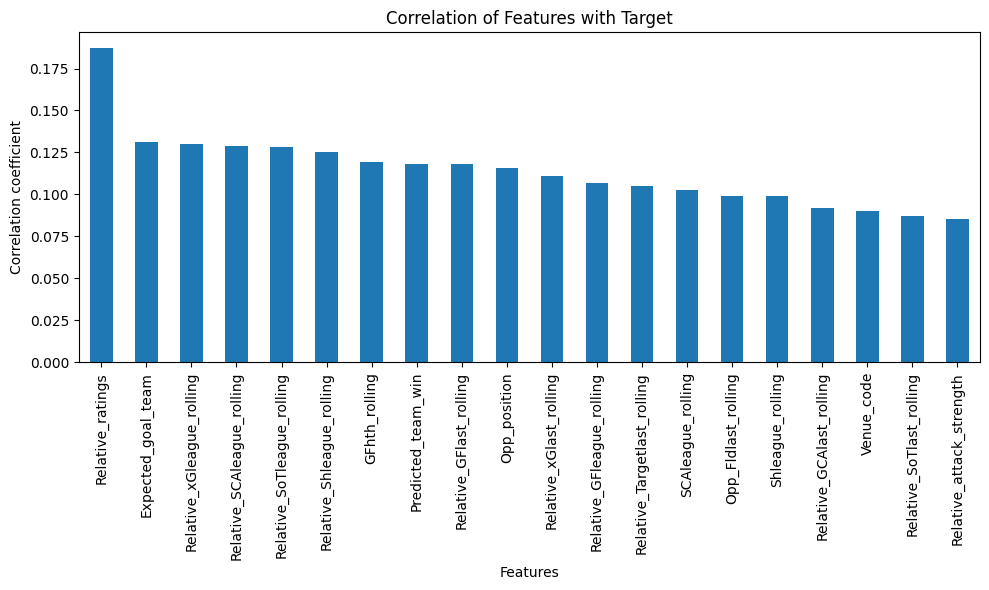

In [52]:
train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
data = train.drop(columns=['Date', 'Target'])

# compute the correlation of features with Target
corr_with_target = data.corrwith(train['Target']).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_with_target.head(20).plot(kind='bar')
plt.title("Correlation of Features with Target")
plt.ylabel("Correlation coefficient")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Creating models and training

In [53]:
predictors = ['Team_code', 'Opp_code', 'Venue_code', 'Hour', 'Day_code']
additional_predictors = ['rolling_rests_1', 'rolling_rests_3',
                           'leaguenum_wins_rolling']
predictors = predictors + league_ravg_new_cols + last_ravg_new_cols + hth_ravg_new_cols + additional_predictors
predictors = predictors + ['Opp_' + column for column in league_ravg_new_cols]
predictors = predictors + ['Opp_' + column for column in last_ravg_new_cols]
predictors = predictors + ['Opp_' + column for column in additional_predictors]
predictors = predictors + ['Relative_pos', 'hthnum_wins_rolling',
                           'Relative_rolling_rests_1', 'Relative_rolling_rests_3',
                           'Relative_leaguenum_wins_rolling', 'Relative_attack_strength',
                           'Relative_defense_strength', 'Predicted_team_win', 'Predicted_team_draw', 
                            'Predicted_team_loss', 'Relative_ratings',
                            'Expected_goal_team', 'Expected_goal_opp']
predictors = predictors + relative_cols

train = past_matches[past_matches['Season'] <= SEASON_SPLIT]
val = train[train['Date'] >= '2024-03-14']
train = train[train['Date'] < '2024-03-14']
test = past_matches[past_matches['Season'] > SEASON_SPLIT]
train_X = train[predictors]
val_X = val[predictors]
test_X = test[predictors]
train_Y = train['Target']
val_Y = val['Target']
test_Y = test['Target']

In [54]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

tscv = TimeSeriesSplit(n_splits=5)

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
clf.fit(train_X, train_Y)
refined_rf_model = clf.best_estimator_
preds = refined_rf_model.predict(test_X)
print(clf.best_params_)
print(classification_report(test_Y, preds, zero_division=0))

{'max_depth': np.int64(8), 'min_samples_split': np.int64(3), 'n_estimators': np.int64(140)}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       107
         1.0       0.48      0.62      0.54       173
         2.0       0.45      0.61      0.52       150

    accuracy                           0.47       430
   macro avg       0.31      0.41      0.35       430
weighted avg       0.35      0.47      0.40       430



In [55]:
feature_importance = pd.Series(refined_rf_model.feature_importances_, index=train_X.columns).sort_values(ascending=False)
feature_importance

Relative_ratings              0.026478
Relative_pos                  0.024169
Relative_SCAleague_rolling    0.018592
Relative_xGleague_rolling     0.015603
Predicted_team_loss           0.015279
                                ...   
PKattlast_rolling             0.000451
PKlast_rolling                0.000401
2CrdYlast_rolling             0.000225
Opp_CrdRlast_rolling          0.000209
Opp_2CrdYlast_rolling         0.000170
Length: 163, dtype: float64

In [56]:
THRESHOLD = 21
selected_features = feature_importance[:THRESHOLD].index
print(len(selected_features))
train_X_selected = train_X[selected_features]
test_X_selected = test_X[selected_features]

21


In [57]:
result = permutation_importance(refined_rf_model, val_X, val_Y, n_repeats=10, random_state=42)

# Convert to DataFrame
importances_df = pd.DataFrame({
    "feature": val_X.columns,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

non_zero_importances = importances_df[:13]

print(non_zero_importances)

                        feature  importance_mean  importance_std
136  Relative_SCAleague_rolling         0.017822        0.010664
130  Relative_Fldleague_rolling         0.015842        0.007921
138   Relative_xGleague_rolling         0.013861        0.004850
119   Relative_GAleague_rolling         0.012871        0.006340
139  Relative_xGAleague_rolling         0.011881        0.008631
105                Relative_pos         0.011881        0.013861
2                    Venue_code         0.010891        0.006931
26            xGAleague_rolling         0.009901        0.009901
115            Relative_ratings         0.009901        0.008856
52                GFhth_rolling         0.008911        0.002970
121  Relative_SoTleague_rolling         0.008911        0.005332
160     Relative_xGlast_rolling         0.007921        0.005941
108    Relative_rolling_rests_3         0.007921        0.005941


In [58]:
features = non_zero_importances['feature']
train_X_selected2 = train_X[features]
test_X_selected2 = test_X[features]

In [59]:
common_features = [feature for feature in features if feature in selected_features]
common_features

['Relative_SCAleague_rolling',
 'Relative_xGleague_rolling',
 'Relative_xGAleague_rolling',
 'Relative_pos',
 'xGAleague_rolling',
 'Relative_ratings',
 'GFhth_rolling',
 'Relative_SoTleague_rolling']

In [60]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_selected)
test_X_scaled = scaler.transform(test_X_selected)
train_X_scaled2 = scaler.fit_transform(train_X_selected2)
test_X_scaled2 = scaler.transform(test_X_selected2)

In [61]:
normalized_sample_weights = compute_sample_weight(class_weight={0:2, 1:1, 2:1}, y=train_Y)
xgboost_model = XGBClassifier(random_state=42)
param_grid = {
    'eta': np.arange(0, 1, 0.1), 
    'max_depth': np.arange(1, 10),
    'alpha': np.arange(0, 10)
}

xgboost_clf = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
xgboost_clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_xgboost_model = xgboost_clf.best_estimator_
better_xgboost_preds = better_xgboost_model.predict(test_X_scaled2)
print(xgboost_clf.best_params_)
print(classification_report(test_Y, better_xgboost_preds, zero_division=0))

{'alpha': np.int64(6), 'eta': np.float64(0.5), 'max_depth': np.int64(4)}
              precision    recall  f1-score   support

         0.0       0.22      0.21      0.22       107
         1.0       0.54      0.56      0.55       173
         2.0       0.49      0.48      0.48       150

    accuracy                           0.45       430
   macro avg       0.42      0.42      0.42       430
weighted avg       0.44      0.45      0.45       430



In [62]:
svc_model = SVC(random_state=42, probability=True)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc_clf = GridSearchCV(estimator=svc_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
svc_clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_svc_model = svc_clf.best_estimator_
better_svc_preds = better_svc_model.predict(test_X_scaled2)
print(svc_clf.best_params_)
print(classification_report(test_Y, better_svc_preds, zero_division=0))

{'C': np.float64(0.30000000000000004), 'kernel': 'linear'}
              precision    recall  f1-score   support

         0.0       0.27      0.29      0.28       107
         1.0       0.57      0.57      0.57       173
         2.0       0.52      0.50      0.51       150

    accuracy                           0.47       430
   macro avg       0.45      0.45      0.45       430
weighted avg       0.48      0.47      0.48       430



In [63]:
lr_model = LogisticRegression(random_state=42, max_iter=100000000)
param_grid = {
    'C': np.arange(0.1, 1, 0.1), 
    'solver': ['saga', 'lbfgs', 'sag', 'newton-cg', 'newton-cholesky']
}

lr_clf = GridSearchCV(estimator=lr_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
lr_clf.fit(train_X_scaled2, train_Y, sample_weight=normalized_sample_weights)
better_lr_model = lr_clf.best_estimator_
better_lr_preds = better_lr_model.predict(test_X_scaled2)
print(lr_clf.best_params_)
print(classification_report(test_Y, better_lr_preds, zero_division=0))

{'C': np.float64(0.1), 'solver': 'lbfgs'}
              precision    recall  f1-score   support

         0.0       0.27      0.29      0.28       107
         1.0       0.55      0.58      0.57       173
         2.0       0.53      0.46      0.49       150

    accuracy                           0.47       430
   macro avg       0.45      0.44      0.45       430
weighted avg       0.47      0.47      0.47       430



In [64]:
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': np.arange(100, 200, 5), 
    'min_samples_split': np.arange(2,10),
    'max_depth': np.arange(2,10)
}

clf = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
clf.fit(train_X_scaled2, train_Y, sample_weight = normalized_sample_weights)
better_rf_model = clf.best_estimator_
better_rf_preds = better_rf_model.predict(test_X_scaled2)
print(clf.best_params_)
print(classification_report(test_Y, better_rf_preds, zero_division=0))

{'max_depth': np.int64(5), 'min_samples_split': np.int64(4), 'n_estimators': np.int64(155)}
              precision    recall  f1-score   support

         0.0       0.18      0.12      0.15       107
         1.0       0.51      0.61      0.56       173
         2.0       0.52      0.53      0.53       150

    accuracy                           0.46       430
   macro avg       0.41      0.42      0.41       430
weighted avg       0.43      0.46      0.44       430



In [65]:
base_estimators = [
    ('rf', better_rf_model),
    ('xgb', better_xgboost_model),
    ('svc', better_svc_model),
    ('lr', better_lr_model)
]

voter = VotingClassifier(estimators=base_estimators, voting='soft')

param_grid = {
    'weights': [(w1, w2, w3, w4) for w1 in range(1,5) for w2 in range(1,5) for w3 in range(1,5) for w4 in range(1,5)]
}

voting_clf = GridSearchCV(estimator=voter, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=tscv)
voting_clf.fit(train_X_scaled2, train_Y, sample_weight=normalized_sample_weights)
refined_voting_model = voting_clf.best_estimator_
voter_preds = refined_voting_model.predict(test_X_scaled2)
voter_proba = refined_voting_model.predict_proba(test_X_scaled2)

print(voting_clf.best_params_)
print(classification_report(test_Y, voter_preds, zero_division=0))

{'weights': (3, 2, 1, 4)}
              precision    recall  f1-score   support

         0.0       0.22      0.15      0.18       107
         1.0       0.54      0.65      0.59       173
         2.0       0.52      0.51      0.52       150

    accuracy                           0.48       430
   macro avg       0.43      0.44      0.43       430
weighted avg       0.45      0.48      0.46       430



In [66]:
voter_proba = np.clip(voter_proba, 0, 1)
voter_proba = voter_proba / voter_proba.sum(axis=1, keepdims=True) 
logloss = log_loss(test_Y, voter_proba)
print("Log Loss:", logloss)

Log Loss: 1.0295281842955726


In [67]:
def multiclass_brier_score(y_true, y_proba):
    y_true = y_true.astype(int)
    n_samples, n_classes = y_proba.shape
    # one-hot encode y_true
    y_true_oh = np.zeros_like(y_proba)
    y_true_oh[np.arange(n_samples), y_true] = 1
    # mean squared error
    return np.mean(np.sum((y_proba - y_true_oh) ** 2, axis=1))

brier = multiclass_brier_score(test_Y, voter_proba)
print("Brier Score:", brier)

Brier Score: 0.6167769828394007


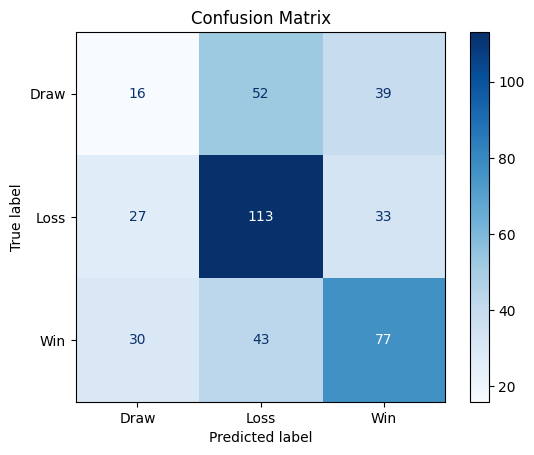

In [68]:
cm = confusion_matrix(test_Y, voter_preds, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Draw", "Loss", "Win"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


## Predicting upcoming matches

In [92]:
full_train_X = pd.concat([train_X_selected2, test_X_selected2])
full_train_Y = pd.concat([train_Y, test_Y])
normalized_sample_weights2 = compute_sample_weight(class_weight={0:2, 1:1, 2:1}, y=full_train_Y)

full_train_X_scaled = scaler.fit_transform(full_train_X)
predict_X = future_matches[features]
predict_X_scaled = scaler.transform(predict_X)

refined_voting_model.fit(full_train_X_scaled, full_train_Y, sample_weight=normalized_sample_weights2)
voter_preds = refined_voting_model.predict(predict_X_scaled)
voter_proba = refined_voting_model.predict_proba(predict_X_scaled)
result_mapping_dict = {0: 'Draw', 1: 'Loss', 2: 'Win'}
voter_preds = [result_mapping_dict.get(result) for result in voter_preds]
team_mapping_dict2 = {value: key for key, value in team_mapping_dict.items()}
team_names = future_matches['Team_code'].map(team_mapping_dict2)
opp_names = future_matches['Opp_code'].map(team_mapping_dict2)
result = pd.DataFrame({'Date': future_matches['Date'],
                       'Team_position': future_matches['Team_position'],
                       'Team':team_names, 
                        'Pred':voter_preds, 'Opponent': opp_names,
                        'Opp_position': future_matches['Opp_position'],
                        'Team_win%': voter_proba[:,2],
                        'Opp_win%': voter_proba[:,1],
                        'Draw%': voter_proba[:,0]})
for col in ['Team_win%', 'Opp_win%', 'Draw%']:
    result[col] = (result[col] * 100).round(2)
result

,Date,Team_position,Team,Pred,Opponent,Opp_position,Team_win%,Opp_win%,Draw%
2380,2025-09-27,6.0,Chelsea,Win,Brighton,14.0,49.46,14.14,36.40
2381,2025-09-27,1.0,Liverpool,Win,Crystal Palace,5.0,41.70,29.13,29.16
2382,2025-09-27,16.0,Burnley,Loss,Manchester City,9.0,6.84,73.05,20.12
2383,2025-09-27,3.0,Tottenham,Win,Wolves,20.0,42.04,17.08,40.88
2384,2025-09-27,7.0,Sunderland,Win,Nott'ham Forest,15.0,34.34,32.68,32.98
2386,2025-09-27,11.0,Manchester Utd,Win,Brentford,17.0,39.14,25.63,35.23
2388,2025-09-27,4.0,Bournemouth,Win,Leeds United,12.0,52.19,17.57,30.23
2394,2025-09-28,13.0,Newcastle Utd,Loss,Arsenal,2.0,16.46,42.19,41.35
2395,2025-09-28,18.0,Aston Villa,Draw,Fulham,8.0,32.96,33.02,34.02
2398,2025-09-29,10.0,Everton,Win,West Ham,19.0,41.39,19.00,39.61


In [99]:
PREDICTIONS_CSV = 'predictions.csv'
predictions_csv_path = os.path.join(os.getcwd(), PREDICTIONS_CSV)
if os.path.exists(predictions_csv_path):
    try:
        csv_all_predictions = pd.read_csv(PREDICTIONS_CSV , index_col=0).sort_values('Date', ascending=False)

        past_matches_home = past_matches[['Date', 'Team_position', 'Opp_position', 'Target']]
        past_matches_away = past_matches_home.rename(columns={'Team_position': 'Opp_position',
                                                                  'Opp_position': 'Team_position'})
        team_opp_swap_target_dict = {1: 2, 2: 1, 0:0}
        past_matches_away['Target'] = past_matches_away['Target'].map(team_opp_swap_target_dict)
        past_matches_selected = pd.concat([past_matches_home, past_matches_away], ignore_index=True)

        csv_all_predictions['Date'] = pd.to_datetime(csv_all_predictions['Date'])
        csv_all_predictions = csv_all_predictions.merge(past_matches_selected[['Date', 'Team_position', 'Opp_position', 'Target']],
                                         on=['Date', 'Team_position', 'Opp_position'],
                                         how='left')
        csv_all_predictions['Actual'] = csv_all_predictions['Actual'].combine_first(csv_all_predictions['Target'])
        csv_all_predictions = csv_all_predictions.drop(columns=['Target'])
        csv_all_predictions['Actual'] = csv_all_predictions['Actual'].map(result_mapping_dict)

        unique_keys = ['Date', 'Team', 'Opponent']
        prediction_mask = ~result.set_index(unique_keys).index.isin(csv_all_predictions.set_index(unique_keys).index)
        prediction_new_unique_matches = result[prediction_mask]

        new_dfs = [df for df in [prediction_new_unique_matches, csv_all_predictions] if not df.empty]
        prediction_matches_df = pd.concat(new_dfs, ignore_index=True)
        prediction_matches_df = prediction_matches_df.drop_duplicates(
            subset=unique_keys, keep='last'
        )
        
        prediction_matches_df.to_csv(PREDICTIONS_CSV)
    except pd.errors.EmptyDataError:
        result['Actual'] = None
        result.to_csv(PREDICTIONS_CSV)